Import library

In [12]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

Download Apple Inc Stock from yahoo finance

In [6]:
#Get the stock quote
# df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now())
#Show teh data
# df.to_csv('input/AAPL_history.csv')

In [542]:
df=pd.read_csv('input/AAPL_history.csv')

define all function that we use in below cell

In [237]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags

# Feature Engineering

In [543]:
# adds columns relevant to a date
add_datepart(df, "Date", drop=False)
df.drop('Elapsed', axis=1, inplace=True) # no need for elapsed

In [544]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [545]:
# Convert year to categorical feature, based on alphabetical order
df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])

In [546]:
# create moving average 
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"ma_for_{ma}_days"
    df[column_name] = df['adj_close'].rolling(ma).mean()

In [547]:
# create percentage change
df['daily_return'] = df['adj_close'].pct_change()

In [548]:
# Create lags 
df = add_lags(df, 10, ['adj_close'])

In [549]:
df.tail(4).T

,2260,2261,2262,2263
date,2020-12-24 00:00:00,2020-12-28 00:00:00,2020-12-29 00:00:00,2020-12-30 00:00:00
high,133.46,137.34,138.79,135.99
low,131.1,133.51,134.34,133.4
open,131.32,133.99,138.05,135.58
close,131.97,136.69,134.87,133.72
volume,5.49301e+07,1.24486e+08,1.21047e+08,9.62927e+07
adj_close,131.97,136.69,134.87,133.72
year,8,8,8,8
month,12,12,12,12
week,52,53,53,53


In [550]:
df.columns

Index(['date', 'high', 'low', 'open', 'close', 'volume', 'adj_close', 'year',
       'month', 'week', 'day', 'dayofweek', 'dayofyear', 'is_month_end',
       'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end',
       'is_year_start', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days',
       'daily_return', 'order_day', 'adj_close_lag_1', 'adj_close_lag_2',
       'adj_close_lag_3', 'adj_close_lag_4', 'adj_close_lag_5',
       'adj_close_lag_6', 'adj_close_lag_7', 'adj_close_lag_8',
       'adj_close_lag_9', 'adj_close_lag_10'],
      dtype='object')

In [552]:
# Compute correlation
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start',
        'MA for 10 days', 'MA for 20 days', 'MA for 50 days',
       'order_day', 'adj_close_lag_1', 'adj_close_lag_2', 'adj_close_lag_3',
       'adj_close_lag_4', 'adj_close_lag_5', 'adj_close_lag_6',
       'adj_close_lag_7', 'adj_close_lag_8', 'adj_close_lag_9',
       'adj_close_lag_10', 'daily_return'
]
# for n in range(N,0,-1):
#     features.append("adj_close_lag_"+str(n))
        
corr_matrix = df[features].corr()
corr_matrix["adj_close"].sort_values(ascending=False)

adj_close           1.000000
adj_close_lag_1     0.999218
adj_close_lag_2     0.998646
MA for 10 days      0.998214
adj_close_lag_3     0.998015
adj_close_lag_4     0.997412
adj_close_lag_5     0.996832
adj_close_lag_6     0.996169
MA for 20 days      0.996108
adj_close_lag_7     0.995620
adj_close_lag_8     0.994912
adj_close_lag_9     0.994357
adj_close_lag_10    0.993623
MA for 50 days      0.989680
order_day           0.834919
year                0.820457
week                0.181327
dayofyear           0.175496
month               0.174271
daily_return        0.052304
day                 0.008091
is_quarter_start    0.004602
is_quarter_end      0.001102
is_month_start     -0.000973
is_month_end       -0.002113
dayofweek          -0.007965
is_year_end        -0.009380
is_year_start            NaN
Name: adj_close, dtype: float64

# Split into train, validation, test

In [572]:
df[['high','low','open','close','volume']].head()

,high,low,open,close,volume
0,14.732142,14.607142,14.621428,14.686786,302220800.0
1,14.810000,14.617143,14.642858,14.765715,260022000.0
2,14.948215,14.738214,14.819643,14.929643,271269600.0
3,15.098214,14.972143,14.991786,15.085714,318292800.0
4,15.276786,15.048214,15.196428,15.061786,394024400.0


In [582]:
display(df[['adj_close']].head().T); df_final[['adj_close']].head().T

,0,1,2,3,4
adj_close,12.669562,12.737655,12.879071,13.013705,12.993064


,0,1,2,3,4
adj_close,0.014608,0.016728,0.021097,0.025215,0.024586


create final table that we want to feed into the model

In [530]:
df_final=df.drop(['high','low','open','close','volume'], axis=1)

In [581]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_final['adj_close'] = scaler.fit_transform(df_final[['adj_close']].values)

In [531]:
# df_final = df_final.set_index('')
df_final['adj_close']=np.log1p(df_final['adj_close'])
# df_final['adj_close'] = df_final['adj_close'].diff()

# modelling

In [532]:
# start_val = '2018-01-01'
start_test = '2019-01-01'

X_train = df_final[df_final['date']<start_test].iloc[:,2:].copy()
X_test = df_final[df_final['date']>=start_test].iloc[:,2:].copy()

y_train = df_final[df_final['date']<start_test]['adj_close'].copy()
y_test = df_final[df_final['date']>=start_test]['adj_close'].copy()

Starting training...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
[20]	training's rmse: 0.0965802	valid_1's rmse: 0.372227
[40]	training's rmse: 0.0367983	valid_1's rmse: 0.263449
[60]	training's rmse: 0.0173498	valid_1's rmse: 0.22664
[80]	training's rmse: 0.0120749	valid_1's rmse: 0.213223
[100]	training's rmse: 0.0104949	valid_1's rmse: 0.208461
[120]	training's rmse: 0.00967683	valid_1's rmse: 0.205993
[140]	training's rmse: 0.00906221	valid_1's rmse: 0.205525
Early stopping, best iteration is:
[129]	training's rmse: 0.00937859	valid_1's rmse: 0.205336
Plotting metrics recorded during training...


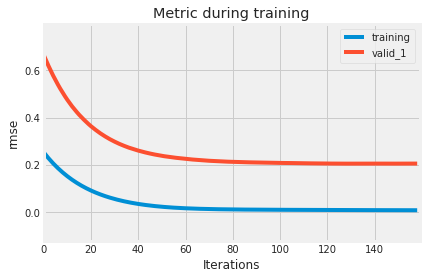

In [533]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train.iloc[:int(len(X_train)*0.8),], y_train.iloc[0:int(len(y_train)*0.8),])
lgb_test = lgb.Dataset(X_train.iloc[int(len(X_train)*0.8)+1:,], y_train.iloc[int(len(y_train)*0.8)+1:,], reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 30,
    'metric': 'rmse',
    'verbose': 0 , 
    'learning_rate':0.05,
    'seed':1000
}

evals_result = {}  # to record eval results for plotting

print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                early_stopping_rounds=30,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,
                verbose_eval=20)

print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

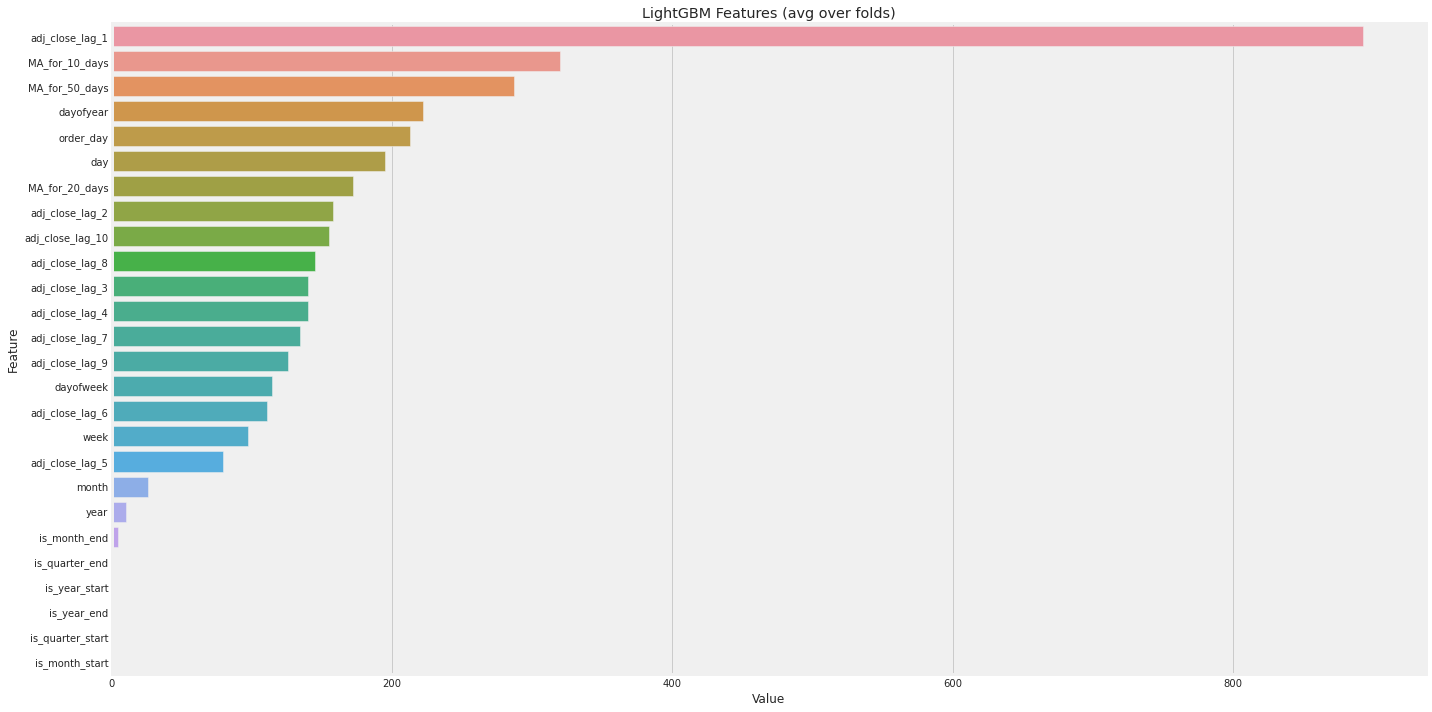

In [534]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),gbm.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [535]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting predicting...
The rmse of prediction is: 0.7083291021149686


In [537]:
start_test

'2019-01-01'

<ipython-input-538-03c127647806>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = np.expm1(y_pred)


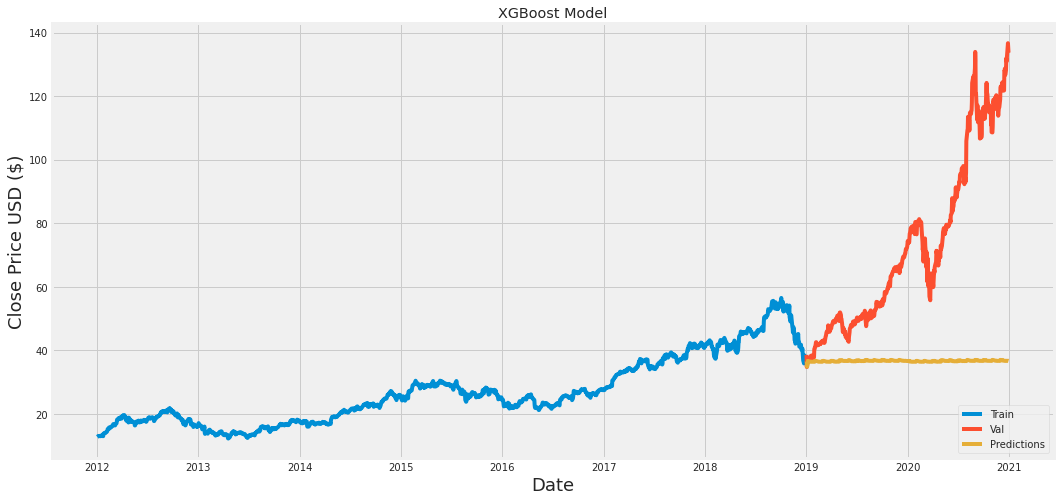

In [538]:
# Plot the data
df2=df.set_index('date')

train = df2.loc[:'2018-12-31']
test = df2.loc[start_test:]

test['Predictions'] = np.expm1(y_pred)
# test['Predictions'] = scaler.inverse_transform([y_pred])[0]

# valid['Predictions'] = y_pred
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('XGBoost Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['adj_close'])
plt.plot(test[['adj_close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Others

In [344]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=100,
                        learning_rate=0.01,
                        n_estimators=1000)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
# print('Feature importances:', list(gbm.feature_importances_))
# print('Feature importances:', list(X_train.columns))

Starting training...
[1]	valid_0's rmse: 91.2626	valid_0's l2: 8328.87
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 91.1041	valid_0's l2: 8299.96
[3]	valid_0's rmse: 90.9472	valid_0's l2: 8271.39
[4]	valid_0's rmse: 90.7918	valid_0's l2: 8243.16
[5]	valid_0's rmse: 90.638	valid_0's l2: 8215.25
[6]	valid_0's rmse: 90.4858	valid_0's l2: 8187.68
[7]	valid_0's rmse: 90.335	valid_0's l2: 8160.42
[8]	valid_0's rmse: 90.1858	valid_0's l2: 8133.48
[9]	valid_0's rmse: 90.0381	valid_0's l2: 8106.86
[10]	valid_0's rmse: 89.8923	valid_0's l2: 8080.62
[11]	valid_0's rmse: 89.7479	valid_0's l2: 8054.68
[12]	valid_0's rmse: 89.6046	valid_0's l2: 8028.98
[13]	valid_0's rmse: 89.4638	valid_0's l2: 8003.77
[14]	valid_0's rmse: 89.3233	valid_0's l2: 7978.66
[15]	valid_0's rmse: 89.1842	valid_0's l2: 7953.83
[16]	valid_0's rmse: 89.0466	valid_0's l2: 7929.29
[17]	valid_0's rmse: 88.9114	valid_0's l2: 7905.23
[18]	valid_0's rmse: 88.7764	valid_0's l2: 7881.25
[19]	valid_0

[161]	valid_0's rmse: 78.3156	valid_0's l2: 6133.34
[162]	valid_0's rmse: 78.2797	valid_0's l2: 6127.72
[163]	valid_0's rmse: 78.2493	valid_0's l2: 6122.95
[164]	valid_0's rmse: 78.2191	valid_0's l2: 6118.23
[165]	valid_0's rmse: 78.1889	valid_0's l2: 6113.5
[166]	valid_0's rmse: 78.1593	valid_0's l2: 6108.88
[167]	valid_0's rmse: 78.1301	valid_0's l2: 6104.31
[168]	valid_0's rmse: 78.1007	valid_0's l2: 6099.73
[169]	valid_0's rmse: 78.0675	valid_0's l2: 6094.53
[170]	valid_0's rmse: 78.0343	valid_0's l2: 6089.36
[171]	valid_0's rmse: 78.0018	valid_0's l2: 6084.27
[172]	valid_0's rmse: 77.9739	valid_0's l2: 6079.93
[173]	valid_0's rmse: 77.9457	valid_0's l2: 6075.53
[174]	valid_0's rmse: 77.9184	valid_0's l2: 6071.27
[175]	valid_0's rmse: 77.8911	valid_0's l2: 6067.02
[176]	valid_0's rmse: 77.8643	valid_0's l2: 6062.86
[177]	valid_0's rmse: 77.8361	valid_0's l2: 6058.45
[178]	valid_0's rmse: 77.8095	valid_0's l2: 6054.32
[179]	valid_0's rmse: 77.7836	valid_0's l2: 6050.28
[180]	valid_0

[345]	valid_0's rmse: 75.612	valid_0's l2: 5717.18
[346]	valid_0's rmse: 75.6072	valid_0's l2: 5716.44
[347]	valid_0's rmse: 75.6023	valid_0's l2: 5715.7
[348]	valid_0's rmse: 75.5975	valid_0's l2: 5714.98
[349]	valid_0's rmse: 75.5929	valid_0's l2: 5714.29
[350]	valid_0's rmse: 75.5882	valid_0's l2: 5713.58
[351]	valid_0's rmse: 75.5841	valid_0's l2: 5712.95
[352]	valid_0's rmse: 75.5784	valid_0's l2: 5712.1
[353]	valid_0's rmse: 75.5739	valid_0's l2: 5711.42
[354]	valid_0's rmse: 75.5684	valid_0's l2: 5710.58
[355]	valid_0's rmse: 75.5639	valid_0's l2: 5709.91
[356]	valid_0's rmse: 75.5595	valid_0's l2: 5709.25
[357]	valid_0's rmse: 75.5552	valid_0's l2: 5708.59
[358]	valid_0's rmse: 75.5509	valid_0's l2: 5707.94
[359]	valid_0's rmse: 75.5456	valid_0's l2: 5707.14
[360]	valid_0's rmse: 75.5415	valid_0's l2: 5706.51
[361]	valid_0's rmse: 75.5363	valid_0's l2: 5705.73
[362]	valid_0's rmse: 75.5321	valid_0's l2: 5705.1
[363]	valid_0's rmse: 75.528	valid_0's l2: 5704.47
[364]	valid_0's r

[515]	valid_0's rmse: 75.2067	valid_0's l2: 5656.04
[516]	valid_0's rmse: 75.2052	valid_0's l2: 5655.83
[517]	valid_0's rmse: 75.2039	valid_0's l2: 5655.63
[518]	valid_0's rmse: 75.2029	valid_0's l2: 5655.48
[519]	valid_0's rmse: 75.2025	valid_0's l2: 5655.42
[520]	valid_0's rmse: 75.2012	valid_0's l2: 5655.22
[521]	valid_0's rmse: 75.2009	valid_0's l2: 5655.17
[522]	valid_0's rmse: 75.1996	valid_0's l2: 5654.98
[523]	valid_0's rmse: 75.1983	valid_0's l2: 5654.79
[524]	valid_0's rmse: 75.1981	valid_0's l2: 5654.75
[525]	valid_0's rmse: 75.1968	valid_0's l2: 5654.56
[526]	valid_0's rmse: 75.1965	valid_0's l2: 5654.51
[527]	valid_0's rmse: 75.1961	valid_0's l2: 5654.46
[528]	valid_0's rmse: 75.1958	valid_0's l2: 5654.4
[529]	valid_0's rmse: 75.1949	valid_0's l2: 5654.27
[530]	valid_0's rmse: 75.1937	valid_0's l2: 5654.09
[531]	valid_0's rmse: 75.1935	valid_0's l2: 5654.06
[532]	valid_0's rmse: 75.1923	valid_0's l2: 5653.88
[533]	valid_0's rmse: 75.1911	valid_0's l2: 5653.7
[534]	valid_0'

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [92]:
""" First import all the required libraries """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score, make_scorer

In [341]:
import lightgbm as lgb
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        early_stopping_rounds=1000, verbose=100)

/home/aswadi/miniconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 19.4086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 19.5685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1100]	valid_0's rmse: 19.6783
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.05, max_bin=512, max_depth=8, metric='rmse',
              n_estimators=1000, num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)